In [22]:
from glob import glob
import pandas as pd
import os
from tqdm import tqdm as tqdm 
from IPython.display import Image
from pathlib import Path
from tqdm import tqdm
import h5py
import math
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import json
import scipy.stats
import time
from types import SimpleNamespace
import random
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [23]:
# !pip install h5py

In [24]:
subject_mapping = {"m00183": "sub_1",
                   "m00184": "sub_2",
                   "m00185": "sub_3",
                   "m00187": "sub_4",
                   "m00188": "sub_5",
                   "m00191": "sub_6",
                   "m00192": "sub_7",
                   "m00193": "sub_8",
                   "m00194": "sub_9",
                   "m00195": "sub_10",
                  }

In [25]:
task_name_mapping = {
        'onset': 'Sentence Onset',
        'speech': 'Speech',
        'volume': 'Volume', 
        'pitch': 'Pitch',
        'speaker': 'Speaker Identity',
        'delta_volume': 'Delta Volume',
        'delta_pitch': 'Delta Pitch',
        'gpt2_surprisal': 'GPT-2 Surprisal',
        'word_length': 'Word Length',
        'word_gap': 'Inter-word Gap',
        'word_index': 'Word Position',
        'word_head_pos': 'Head Word Position',
        'word_part_speech': 'Part of Speech',
        'frame_brightness': 'Frame Brightness',
        'global_flow': 'Global Optical Flow',
        'local_flow': 'Local Optical Flow',
        'global_flow_angle': 'Global Flow Angle',
        'local_flow_angle': 'Local Flow Angle',
        'face_num': 'Number of Faces',
    }

In [26]:
ls brain_plotting

all_electrodes.png       left_all_electrodes.png  right_all_electrodes.png
brain_plotting_utils.py  left_hem_clean.png       right_hem_clean.png
elec_coords.csv          pos_co_sig_bar.png
elec_coords_full.csv     pos_cos_sig_bar.png


In [27]:
task_order =  ['onset', 'speech', 'volume', 'pitch', 'speaker', 'delta_volume', 'delta_pitch', 'gpt2_surprisal', 'word_length', 'word_gap', 'word_index', 'word_head_pos', 'word_part_speech', 'frame_brightness', 'global_flow', 'local_flow', 'global_flow_angle', 'local_flow_angle', 'face_num']

In [28]:
# results_root = "/storage/czw/linear_voltage_single_electrode_SS_SM_prototype/linear_voltage_single_electrode"
results_root = "/storage/czw/btbench/single_electrode_btbench_full/eval_results_full_SS_SM/linear_voltage_single_electrode"


In [29]:
# ls /storage/czw/btbench/single_electrode_btbench_full/eval_results_full_SS_SM/linear_voltage_single_electrode

In [30]:
# results

In [31]:
def get_test_results(results, eval_name):
    eval_results = results["evaluation_results"]
    assert len(eval_results.keys()) == 1
    records = []
    for subject_trial in eval_results:
        subject = subject_trial.split("_")[0][len("btbank"):]
        trial = subject_trial.split("_")[1]
        subject_trial_results = eval_results[subject_trial]['electrode']
        for electrode in subject_trial_results:
            electrode_results = subject_trial_results[electrode]
            time_bin_results = electrode_results["time_bins"]
            for time_bin in time_bin_results:
                time_bin_start = time_bin['time_bin_start']
                fold_results = time_bin['folds']
                avg_test = np.mean([f['test_roc_auc'] for f in fold_results])
                records.append({
                    "subject": subject,
                    "trial": trial,
                    "ID": f'{electrode}-sub_{subject}',
                    "electrode": electrode,
                    "avg_test": avg_test,
                    "time_bin": time_bin_start,
                    "task": eval_name
                })
        return records

In [32]:
all_records = []
all_results_paths = glob(os.path.join(results_root, "*"))
for path in tqdm(all_results_paths):
    name = Path(path).stem
    sub_id = name.split("_")[1][len("btbank"):]
    trial_id = name.split("_")[2]
    eval_name = "_".join(name.split("_")[3:])
    with open(path, "r") as f:
        results = json.load(f)
        test_results = get_test_results(results, eval_name)
    all_records += test_results
results_df = pd.DataFrame.from_records(all_records)

100%|██████████████████████████████████████████████████████████████████████████████████| 494/494 [00:29<00:00, 16.92it/s]


In [33]:
matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

save_dir = 'brain_plotting/'
base_path = 'brain_plotting/'
left_hem_file_name = 'left_hem_clean.png'
right_hem_file_name = 'right_hem_clean.png'
coords_file_name = 'elec_coords_full.csv'
correlations_file = 'lag_correlation.json'

left_hem_img = plt.imread(os.path.join(base_path, left_hem_file_name))
right_hem_img = plt.imread(os.path.join(base_path, right_hem_file_name))
coords_df = pd.read_csv(os.path.join(base_path, coords_file_name))
split_elec_id = coords_df['ID'].str.split('-')
coords_df['Subject'] = [subject_mapping[t[0]] for t in split_elec_id]
coords_df['Electrode'] = [t[1] for t in split_elec_id]

# # Scale Matlab electrode locations to Python format
def scale(x, s, d):
    return -(x - d) * s

x_scale = left_hem_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

y_scale_r = right_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

scaled_coords_df = coords_df.copy()

# scale left hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'X'].apply(lambda x: scale(x, x_scale, matlab_xlim[1]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'Y'].apply(lambda x: scale(x, y_scale_l, matlab_ylim[1]))

# scale right hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'X'].apply(lambda x: -scale(x, y_scale_r, matlab_xlim[0]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'Y'].apply(lambda x: scale(x, y_scale_r, matlab_ylim[1]))

# scaled_coords_df[]
scaled_coords_df["ID"] = scaled_coords_df.Electrode + "-" + scaled_coords_df.Subject

In [34]:
import seaborn as sns
def plot_electrodes(plot_df, ax=None, hemisphere="left", title=None):
    plot_df = plot_df.dropna() #TODO NOTE
    plot_df = plot_df.sort_values(by='avg_test', ascending=True)

    ax.set_aspect('equal')

    if hemisphere=="left":
        ax.imshow(left_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==1]
    elif hemisphere=="right":
        ax.imshow(right_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==0]


    ax.axis('off')
    assert hemisphere in ["left", "right"]


    plot_title = f'{hemisphere} hemisphere'

    if title:
        plot_title += f' {title}'

    all_x = plot_df['X']
    all_y = plot_df['Y']
    color = plot_df['avg_test']
    assert(list(sorted(color))==list(color))
    sc = ax.scatter(all_x, all_y,
                s=50,
                linewidths=1,
                c=color,
                edgecolors="black",
                clip_on=False,
                cmap="viridis",
                vmin=0.48,
                vmax=0.60,
                   )
    return sc

In [35]:
# all_results_paths

In [36]:
np.percentile(results_df["avg_test"],95)

np.float64(nan)

In [37]:
spatial_avg_results_df = results_df.groupby(['task','ID']).max(['avg_test'])

In [38]:
# tasks

In [39]:
# tasks = list(set(results_df.task))
tasks = task_order

/tmp/ipykernel_2107709/1547264026.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


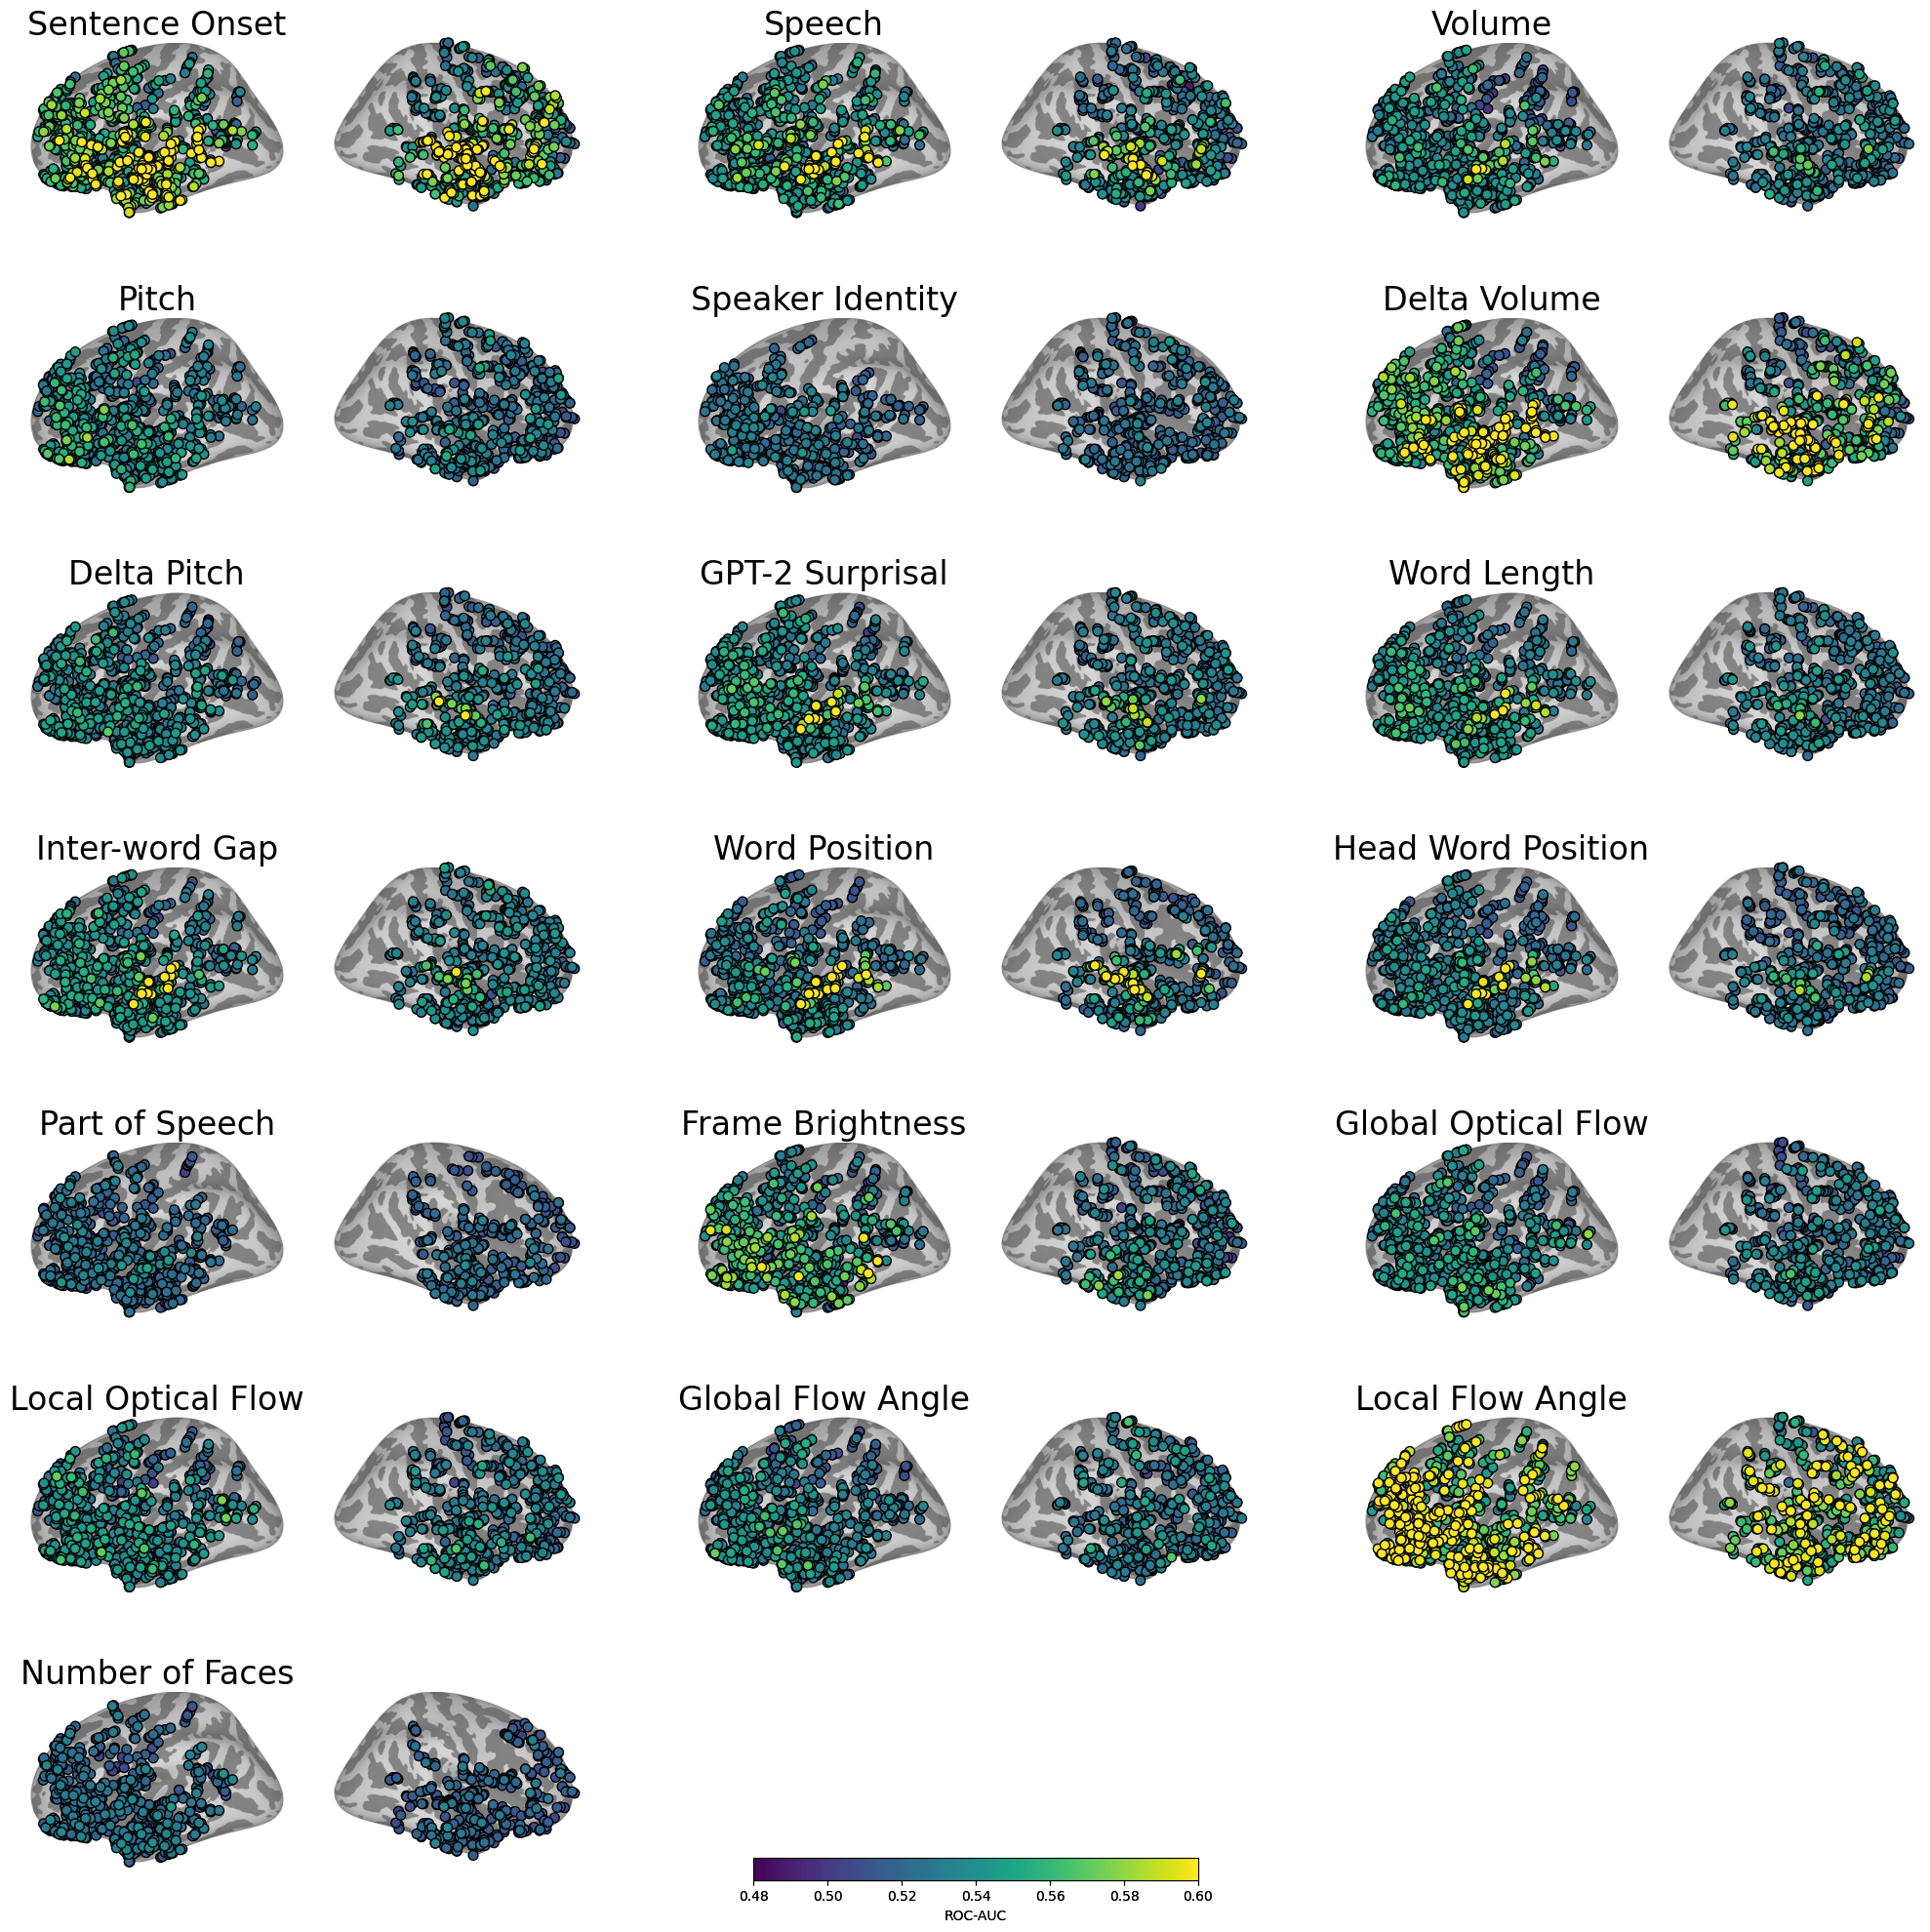

In [40]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(25, 25))

num_cols = 3
num_rows = 7
outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.2)

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        if i*num_cols+j >= 19:
            ax = fig.add_subplot(outer[19])
            cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', shrink=0.8)
            cbar.set_label("ROC-AUC")
            ax.set_axis_off()
            continue
            
        # Define inner 2x1 grid within this cell
        inner = gridspec.GridSpecFromSubplotSpec(
            1, 2, subplot_spec=outer[outer_idx], hspace=0.1
        )
            
        for k in range(2):
            ax = fig.add_subplot(inner[k])
#             print(i*4+j)
            task = task_order[i*num_cols+j]
            task_df = spatial_avg_results_df.loc[task]
            # task_df.loc[:,'avg_test'] = np.log(100*task_df['avg_test'])
            merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")
            hem = ["left","right"][k]
            sc = plot_electrodes(merged_df, hemisphere=hem, ax=ax, title=task)
#             ax.set_title(task)
            
            if k == 0:
                ax.set_title(task_name_mapping[task], fontsize=24)
                
plt.tight_layout()

In [41]:
merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")


In [42]:
# sorted(list(merged_df.dropna().sort_values(by='avg_test', ascending=True)['avg_test']))

In [43]:
len(tasks)

19

In [44]:
import seaborn as sns



/tmp/ipykernel_2107709/974333989.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


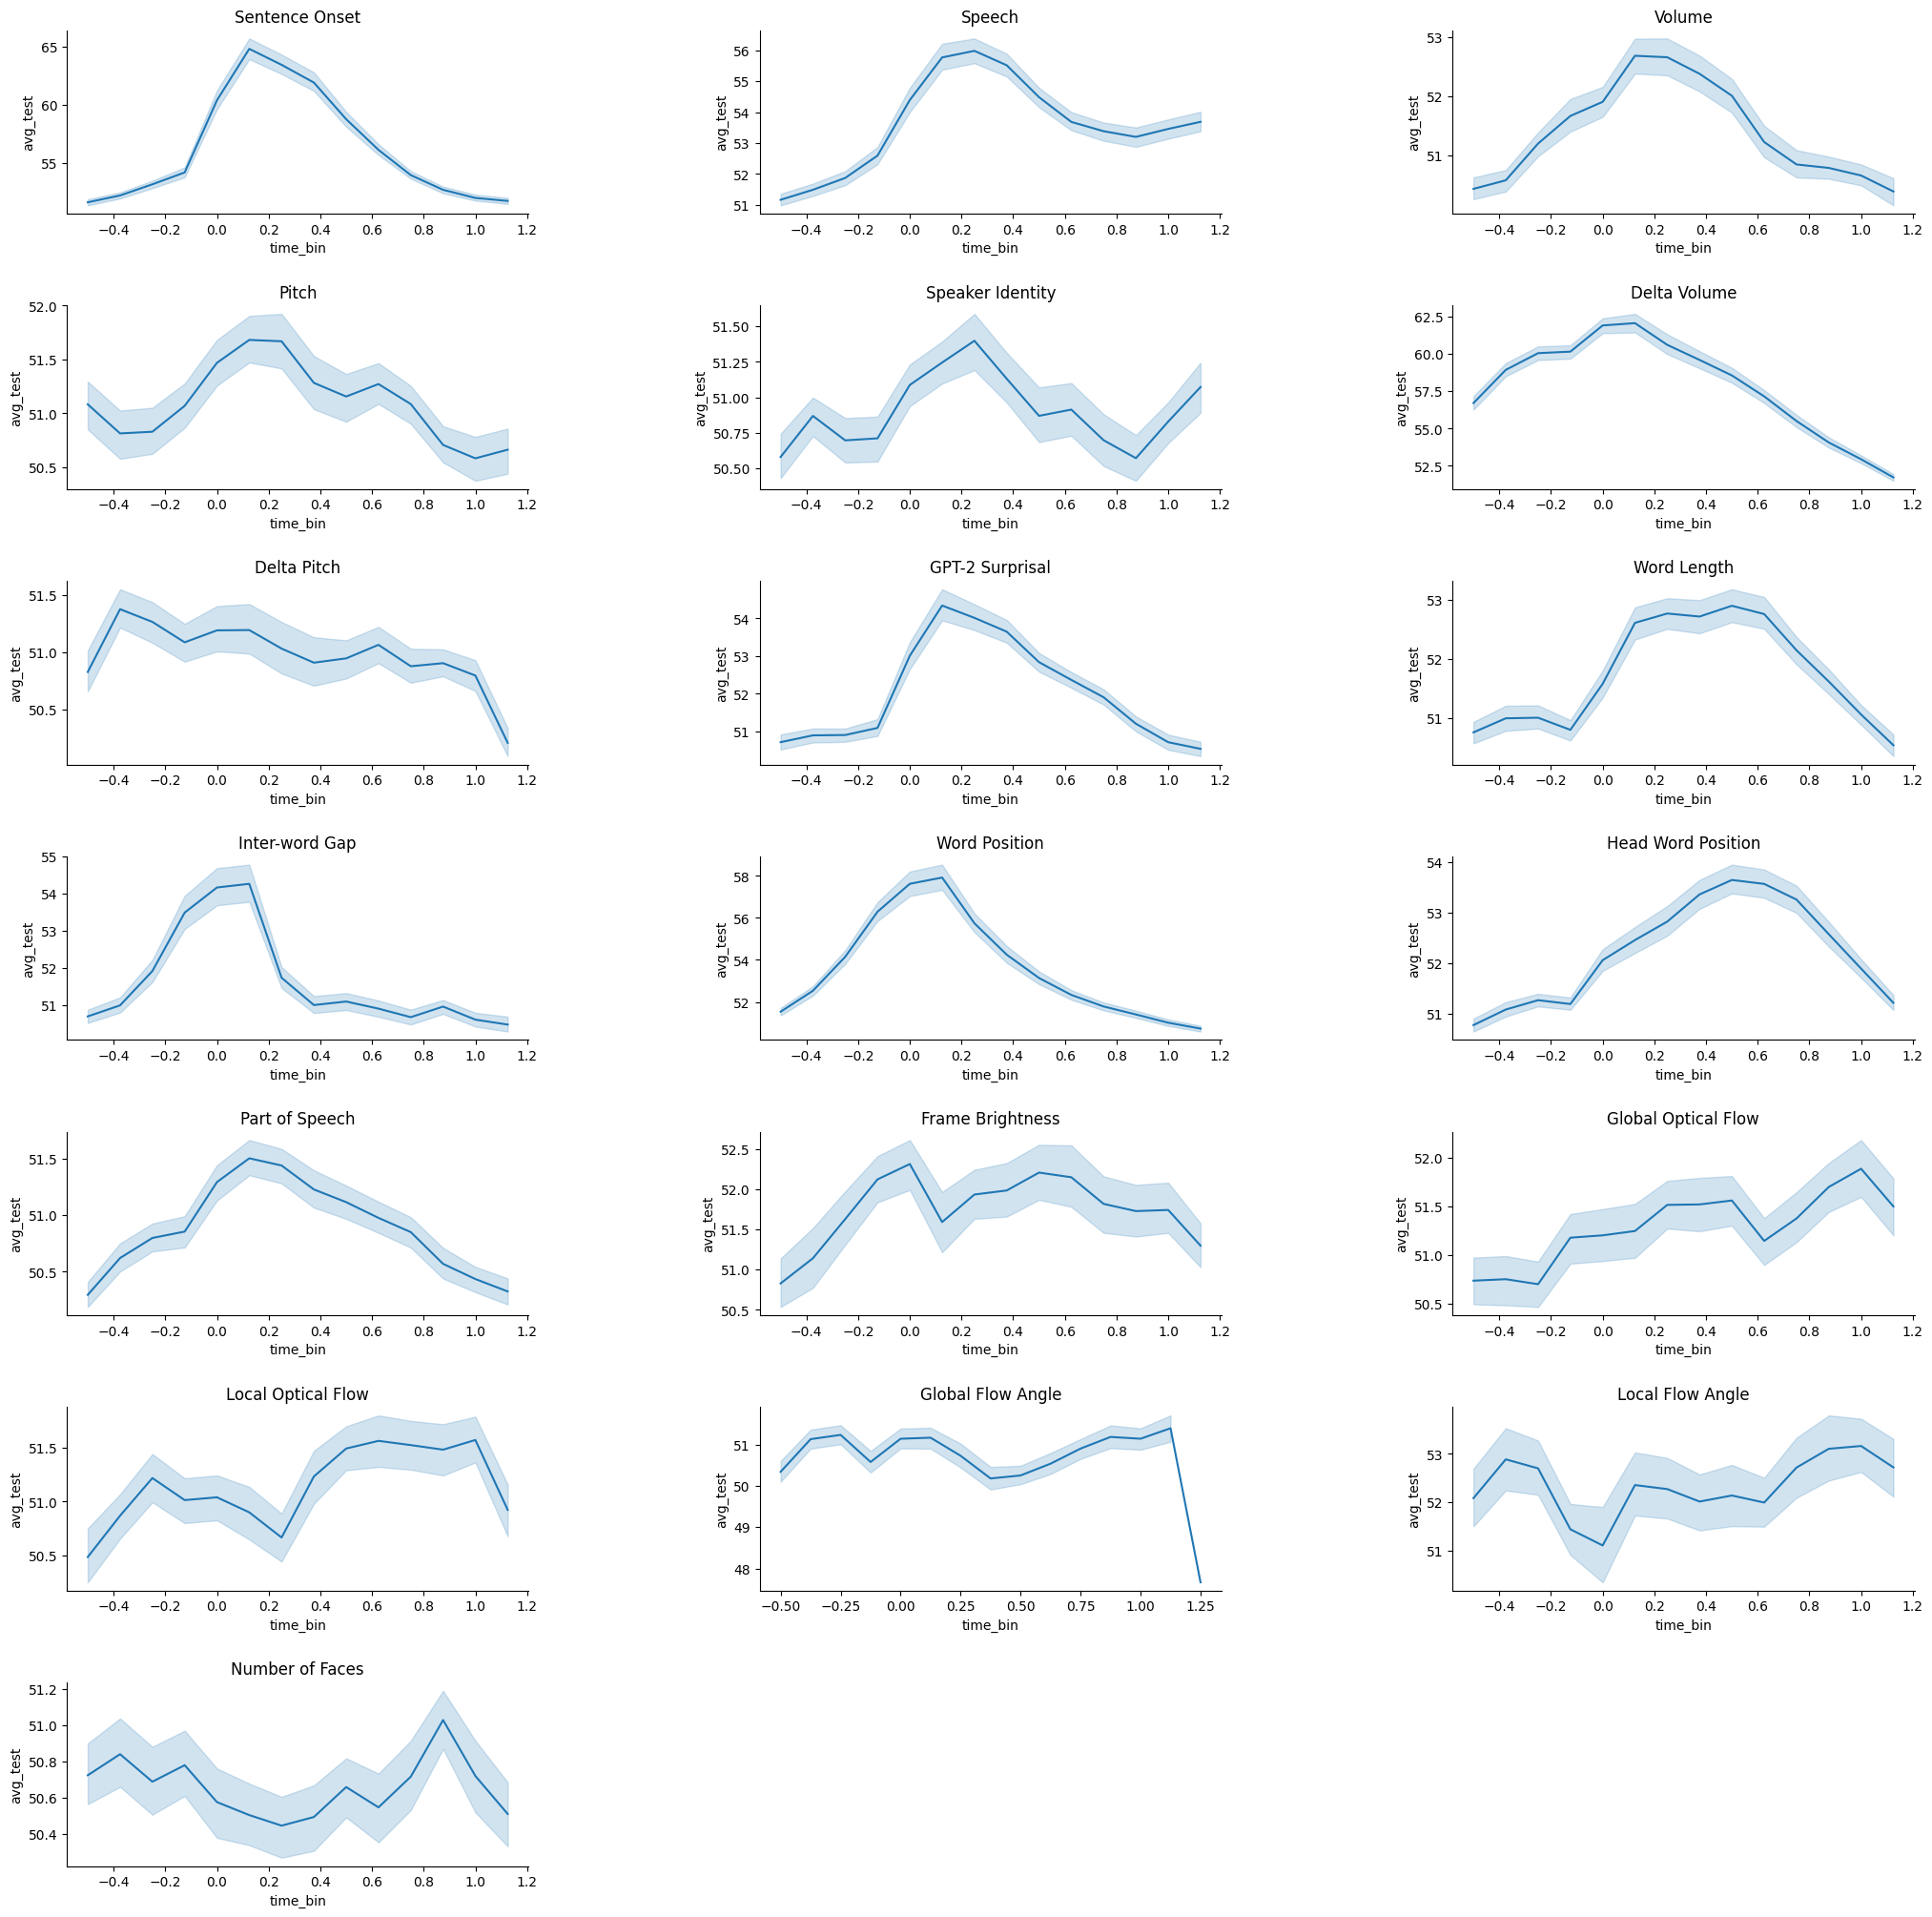

In [45]:
fig = plt.figure(figsize=(25, 25))

outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.5, hspace=0.5)

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        if i*num_cols+j >= 19:
            continue

        ax = fig.add_subplot(outer[outer_idx])
        task = task_order[i*num_cols+j]

        task_df = results_df[results_df.task==task].groupby("ID").mean(["avg_test"])
#         good_elecs = task_df[task_df.avg_test>0.5].index   
        
        good_elecs = results_df[results_df.task==task].groupby("ID").mean(["avg_test"]).sort_values(by="avg_test").dropna()[-100:].index  
        time_df = results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))]
        time_df.loc[:,'avg_test'] = [(100*x) for x in time_df['avg_test']]
        
#         time_df = results_df[(results_df.task==task)]

        # sns.set(style="whitegrid")

        # Create lineplot
        g = sns.lineplot(data=time_df, x="time_bin", y="avg_test")
        # plt.axis("off")  # disables the entire axis (spines, ticks, labels, etc.)
        plt.grid(False)  # ensures grid lines are also off
        ax.set_title(task_name_mapping[task])
        sns.despine() 
        # plt.yscale('log')
        # plt.ylim(50, 70)
        # for axes in g.axes:
        # ax.set_ylabel("ROC-AUC")plt.ticklabel_format(axis='y', style='plain')             # <---- error


# from matplotlib.ticker import ScalarFormatter
# plt.gca().yaxis.set_major_formatter(ScalarFormatter()) 
# plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
        
        # from matplotlib.ticker import ScalarFormatter
        # plt.gca().yaxis.set_major_formatter(ScalarFormatter()) 
        # plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
plt.tight_layout()

In [46]:
results_df[results_df.task==task].groupby("ID").mean(["avg_test"])

,avg_test,time_bin
ID,,
F1aCaOFb1-sub_8,0.502095,0.3125
F1aCaOFb10-sub_8,0.498982,0.3125
F1aCaOFb11-sub_8,0.515432,0.3125
F1aCaOFb12-sub_8,0.501808,0.3125
F1aCaOFb13-sub_8,0.505296,0.3125
...,...,...
T3bOT4-sub_1,0.503376,0.3125
T3bOT5-sub_1,0.498707,0.3125
T3bOT6-sub_1,0.495178,0.3125


In [48]:
task = "speaker"
# good_elecs = results_df[results_df.task==task].groupby("ID").mean().sort_values(by="avg_test").dropna()[-100:].index
# good_elecs = task_df[task_df.avg_test>0.5].index   
# results_df

In [51]:
# results_df[results_df.task==task].groupby("ID").mean().sort_values(by="avg_test").dropna()[-100:]

In [52]:
# results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))]
# results_df[(results_df.task==task)]
task

'speaker'

In [53]:
'speaker' in set(results_df.task)

True

In [54]:
task_df = results_df[results_df.task=="speaker"]
# task_df[task_df.isnull().any(axis=1)]
task_df.dropna()

,subject,trial,ID,electrode,avg_test,time_bin,task
203434,2,2,LT3a1-sub_2,LT3a1,0.488910,-0.500,speaker
203435,2,2,LT3a1-sub_2,LT3a1,0.492343,-0.375,speaker
203436,2,2,LT3a1-sub_2,LT3a1,0.494262,-0.250,speaker
203437,2,2,LT3a1-sub_2,LT3a1,0.498331,-0.125,speaker
203438,2,2,LT3a1-sub_2,LT3a1,0.497798,0.000,speaker
...,...,...,...,...,...,...,...
898813,1,0,T2d6-sub_1,T2d6,0.515533,0.625,speaker
898814,1,0,T2d6-sub_1,T2d6,0.488354,0.750,speaker
898815,1,0,T2d6-sub_1,T2d6,0.499355,0.875,speaker
898816,1,0,T2d6-sub_1,T2d6,0.498609,1.000,speaker


In [55]:
task_df[task_df.avg_test>0.5].index

Index([203444, 203452, 203457, 203458, 203472, 203485, 203486, 203494, 203496,
       203499,
       ...
       898804, 898805, 898806, 898807, 898809, 898810, 898811, 898812, 898813,
       898817],
      dtype='int64', length=14495)

In [56]:
results_df

,subject,trial,ID,electrode,avg_test,time_bin,task
0,9,0,T1b1-sub_9,T1b1,0.481273,-0.500,speech
1,9,0,T1b1-sub_9,T1b1,0.477107,-0.375,speech
2,9,0,T1b1-sub_9,T1b1,0.494581,-0.250,speech
3,9,0,T1b1-sub_9,T1b1,0.479030,-0.125,speech
4,9,0,T1b1-sub_9,T1b1,0.481981,0.000,speech
...,...,...,...,...,...,...,...
1004639,3,0,O1bId16-sub_3,O1bId16,0.521015,0.625,gpt2_surprisal
1004640,3,0,O1bId16-sub_3,O1bId16,0.506986,0.750,gpt2_surprisal
1004641,3,0,O1bId16-sub_3,O1bId16,0.490335,0.875,gpt2_surprisal
1004642,3,0,O1bId16-sub_3,O1bId16,0.504640,1.000,gpt2_surprisal


In [58]:
#https://bookdown.org/u0243256/tbicc/freesurfer.html
dk2text_d = {'supramarginal': 'supramarginal',
             'postcentral': 'postcentral',
             'medialorbitofrontal': 'medial orbitofrontal',
             'caudalmiddlefrontal': 'caudal middle frontal',
             'posteriorcingulate': 'posterior cingulate',
             'middletemporal': 'middle temporal',
             'superiortemporal': 'superior temporal',
             'bankssts': 'Banks of sup. temp. sul.',
             'superiorparietal': 'superior parietal',
             'precuneus': 'precuneus',
             'entorhinal': 'entorhinal',
             'parstriangularis': 'pars triangularis',
             'precentral': 'precentral',
             'parsorbitalis': 'pars orbitalis',
             'insula': 'insula',
             'parahippocampal': 'parahippocampal',
             'inferiortemporal': 'inferior temporal',
             'parsopercularis': 'pars opercularis',
             'fusiform': 'fusiform',
             'transversetemporal': 'transverse temporal',
             'superiorfrontal': 'superior frontal',
             'paracentral': 'paracentral',
             'lateralorbitofrontal': 'lateral orbitofrontal',
             'caudalanteriorcingulate': 'caudal anterior cingulate',
             'inferiorparietal': 'inferior parietal',
             'rostralanteriorcingulate': 'rostral anterior cingulate',
             'isthmuscingulate': 'isthmus cingulate',
             'temporalpole': 'temporal pole',
             'rostralmiddlefrontal': 'rostral middle frontal',
             'amygdala': 'Amygdala',
             'hippocampus': 'Hippocampus',
             'inf-lat-vent': 'inferior lateral ventrical',
             'putamen': 'putamen',
             'unknown': 'unknown'}

dk_names = ["superior frontal", "rostral middle frontal", "caudal middle frontal", "pars opercularis",
           "pars triangularis", "pars orbitalis", "lateral orbitofrontal", "medial orbitofrontal",
           "precentral", "paracentral", "frontal pole", "superior parietal", "inferior parietal",
           "supramarginal", "postcentral", "precuneus", "superior temporal", "middle temporal",
           "inferior temporal", "bankssts", "fusiform", "transverse temporal",
           "entorhinal","temporal pole", "parahippocampal", "lateral occipital", "lingual", "cuneus",
           "pericalcarine","rostral anterior cingulate", "caudal anterior cingulate",
           "posterior cingulate","isthmus cingulate", "insula"]

region_ids = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6]
name2region_id = {n:x for x,n in zip(region_ids, dk_names)}
region_id2region_name = {x+1:n for x,n in enumerate(["Frontal", "Parietal", "Temporal", "Occipital", "Cingulate", "Insula"])}

def dk2text(label):
    l = label.replace('ctx-','')
    l = l.replace('rh-','')
    l = l.replace('lh-','')
    l = l.replace('Left-','')
    l = l.replace('Right-','')
    l = l.lower()
    return dk2text_d[l]

def dk2region(label):
    dk_name = dk2text(label)
    if dk_name in name2region_id:
        return region_id2region_name[name2region_id[dk_name]]
    return dk_name

In [59]:
all_localization_dfs = []
braintreebank_root = "/storage/czw/braintreebank_data/"
for fpath in glob(os.path.join(braintreebank_root, "localization/sub_*/depth-wm.csv")):
    sub_localization_df = pd.read_csv(fpath)
    sub_localization_df["Subject"] = subject = os.path.dirname(fpath).split("/")[-1]
    all_localization_dfs.append(sub_localization_df)
all_localization_df = pd.concat(all_localization_dfs)

all_localization_df["region_common_name"] = [dk2region(x) for x in all_localization_df.DesikanKilliany]
all_localization_df["common_name"] = [dk2text(x) for x in all_localization_df.DesikanKilliany]

In [60]:
# all_localization_dfs = {}
subject

'sub_4'

In [61]:
all_localization_df["ID"] = all_localization_df.Electrode + "-" + all_localization_df.Subject

In [62]:
localization_merged_df = pd.merge(results_df, all_localization_df, on="ID", how="left")

In [63]:
localization_merged_df

,subject,trial,ID,electrode,avg_test,time_bin,task,Electrode,L,I,P,DesikanKilliany,Destrieux,DKT,ShiftDist,ConfType,Subject,region_common_name,common_name
0,9,0,T1b1-sub_9,T1b1,0.481273,-0.500,speech,T1b1,174.0,121.0,138.0,ctx-lh-transversetemporal,ctx_lh_G_temp_sup-G_T_transv,ctx-lh-transversetemporal,0.0,1.0,sub_9,Temporal,transverse temporal
1,9,0,T1b1-sub_9,T1b1,0.477107,-0.375,speech,T1b1,174.0,121.0,138.0,ctx-lh-transversetemporal,ctx_lh_G_temp_sup-G_T_transv,ctx-lh-transversetemporal,0.0,1.0,sub_9,Temporal,transverse temporal
2,9,0,T1b1-sub_9,T1b1,0.494581,-0.250,speech,T1b1,174.0,121.0,138.0,ctx-lh-transversetemporal,ctx_lh_G_temp_sup-G_T_transv,ctx-lh-transversetemporal,0.0,1.0,sub_9,Temporal,transverse temporal
3,9,0,T1b1-sub_9,T1b1,0.479030,-0.125,speech,T1b1,174.0,121.0,138.0,ctx-lh-transversetemporal,ctx_lh_G_temp_sup-G_T_transv,ctx-lh-transversetemporal,0.0,1.0,sub_9,Temporal,transverse temporal
4,9,0,T1b1-sub_9,T1b1,0.481981,0.000,speech,T1b1,174.0,121.0,138.0,ctx-lh-transversetemporal,ctx_lh_G_temp_sup-G_T_transv,ctx-lh-transversetemporal,0.0,1.0,sub_9,Temporal,transverse temporal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004639,3,0,O1bId16-sub_3,O1bId16,0.521015,0.625,gpt2_surprisal,O1bId16,175.0,98.0,191.0,ctx-lh-inferiorparietal,ctx_lh_G_occipital_middle,ctx-lh-inferiorparietal,0.0,0.0,sub_3,Parietal,inferior parietal
1004640,3,0,O1bId16-sub_3,O1bId16,0.506986,0.750,gpt2_surprisal,O1bId16,175.0,98.0,191.0,ctx-lh-inferiorparietal,ctx_lh_G_occipital_middle,ctx-lh-inferiorparietal,0.0,0.0,sub_3,Parietal,inferior parietal
1004641,3,0,O1bId16-sub_3,O1bId16,0.490335,0.875,gpt2_surprisal,O1bId16,175.0,98.0,191.0,ctx-lh-inferiorparietal,ctx_lh_G_occipital_middle,ctx-lh-inferiorparietal,0.0,0.0,sub_3,Parietal,inferior parietal
1004642,3,0,O1bId16-sub_3,O1bId16,0.504640,1.000,gpt2_surprisal,O1bId16,175.0,98.0,191.0,ctx-lh-inferiorparietal,ctx_lh_G_occipital_middle,ctx-lh-inferiorparietal,0.0,0.0,sub_3,Parietal,inferior parietal


In [64]:
data = localization_merged_df.groupby('common_name').mean()[["avg_test"]]
data = data[~(data.index=="unknown")]
data = data.sort_values(by="avg_test")
data = data.reset_index()
data.common_name = [x.capitalize() for x in data.common_name]
f = plt.figure(figsize=[5,9])

order = data.index
# sns.barplot(data=data, x="common_name", y="onset_sig", color="grey")
sns.barplot(data=data, y="common_name", x="avg_test", color="white", edgecolor="black")
sns.despine()

plt.tick_params(labelsize=25)
plt.ylabel("")
plt.xlabel("Percent of electrodes", size=20)
plt.figure(dpi=900)

TypeError: agg function failed [how->mean,dtype->object]

In [65]:
data

NameError: name 'data' is not defined

# make timeline

In [ ]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.dates as mdates

In [ ]:
# In case the above fails, e.g. because of missing internet connection
# use the following lists as fallback.
releases = ['2.2.4', '3.0.3', '3.0.2', '3.0.1', '3.0.0', '2.2.3',
            '2.2.2', '2.2.1', '2.2.0', '2.1.2', '2.1.1', '2.1.0',
            '2.0.2', '2.0.1', '2.0.0', '1.5.3', '1.5.2', '1.5.1',
            '1.5.0', '1.4.3', '1.4.2', '1.4.1', '1.4.0']
dates = ['2019-02-26', '2019-02-26', '2018-11-10', '2018-11-10',
         '2018-09-18', '2018-08-10', '2018-03-17', '2018-03-16',
         '2018-03-06', '2018-01-18', '2017-12-10', '2017-10-07',
         '2017-05-10', '2017-05-02', '2017-01-17', '2016-09-09',
         '2016-07-03', '2016-01-10', '2015-10-29', '2015-02-16',
         '2014-10-26', '2014-10-18', '2014-08-26']

dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]  # Convert strs to dates.
releases = [tuple(release.split('.')) for release in releases]  # Split by component.
dates, releases = zip(*sorted(zip(dates, releases)))  # Sort by increasing date.

In [ ]:
releases

In [ ]:
results_df[(results_df.task=="onset")].groupby("time_bin").mean("avg_test")

In [ ]:
task_name_mapping = {
        'onset': 'Sentence Onset',
        'speech': 'Speech',
        'volume': 'Volume', 
        'pitch': 'Pitch',
        'speaker': 'Speaker Identity',
        'delta_volume': 'Delta Volume',
        'delta_pitch': 'Delta Pitch',
        'gpt2_surprisal': 'GPT-2 Surprisal',
        'word_length': 'Word Length',
        'word_gap': 'Inter-word Gap',
        'word_index': 'Word Position',
        'word_head_pos': 'Head Word Position',
        'word_part_speech': 'Part of Speech',
        'frame_brightness': 'Frame Brightness',
        'global_flow': 'Global Optical Flow',
        'local_flow': 'Local Optical Flow',
        'global_flow_angle': 'Global Flow Angle',
        'local_flow_angle': 'Local Flow Angle',
        'face_num': 'Number of Faces',
    }

In [ ]:
records = []
for task in task_order:
    good_elecs = results_df[results_df.task==task].groupby("ID").mean(["avg_test"]).sort_values(by="avg_test").dropna()[-100:].index  
    time_df = results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))]
    
    time_df = time_df.groupby("time_bin").mean("avg_test")
    time_df['time_bin'] = time_df.index
    # time_df
    time = time_df.sort_values(by="avg_test").reset_index(drop=True).iloc[-1]["time_bin"]
    records.append({"time_bin": time,
                    "task": task_name_mapping[task]})
argmax_time = pd.DataFrame.from_records(records)
# time_df

In [ ]:
argmax_time = argmax_time.sort_values(by="time_bin")
argmax_time.reset_index(drop=True)

In [ ]:
dates = list(argmax_time.time_bin)
releases = list(argmax_time.task)


In [ ]:
# Choose some nice levels: alternate meso releases between top and bottom, and
# progressively shorten the stems for micro releases.
levels = []
for i in range(len(releases)):
    release = releases[i]
    date = dates[i]
    h = 1 + 0.8 * (5)
    # print(date)
    if i>0 and (date-dates[i-1])<=0.125:
    # left_nbr = 
        # print("trig")
        h = levels[i-1] - 0.8
    # else:
        # print("no trig")
    level = h 
    levels.append(level)


def is_feature(release):
    """Return whether a version (split into components) is a feature release."""
    return release[-1] == '0'


# The figure and the axes.
fig, ax = plt.subplots(figsize=(10.8, 4), layout="constrained")
ax.set(title="Location of decodability peak")

# The vertical stems.
ax.vlines(dates, 0, levels,
          color=[("tab:red", 1) for release in releases])
# The baseline.
ax.axhline(0, c="black")
# The markers on the baseline.
micro_dates = [date for date, release in zip(dates, releases)
               if not is_feature(release)]
ax.plot(micro_dates, np.zeros_like(micro_dates), "ko", mfc="white")

# Annotate the lines.
for date, level, release in zip(dates, levels, releases):
    version_str = release
    ax.annotate(version_str, xy=(date, level),
                xytext=(3, np.sign(level)*3), textcoords="offset points",
                verticalalignment="bottom",
                weight="bold" if is_feature(release) else "normal",
                bbox=dict(boxstyle='square', pad=0, lw=0, fc=(1, 1, 1, 0.7)))

# ax.xaxis.set(major_locator=mdates.YearLocator(),
             # major_formatter=mdates.DateFormatter("%Y"))

# Remove the y-axis and some spines.
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.set_xlabel("Time (s)")
ax.margins(y=0.1)
plt.show()